## <font color=#0099CC>mIAx - Taller Renta Fija - ANÁLISIS CARTERA DE RENTA FIJA</font>

En esta práctica, desarrollaremos un análisis relativamente exahustivo de un universo de Renta Fija, en concreto, de bonos corporativos. Además, construiremos y analizaremos varias carteras. 

Para ello, contaremos con la siguiente información almacenada en la carpeta *data*:
- Universo de bonos, con sus características esenciales (fichero *universo.csv*)
- Histórico de precios de cierre del universo de bonos anterior (fichero *precios_historicos_universo.csv*)
- Curva de tipos de interés €STR (fichero *curvaESTR.csv*)
- Histórico de precios de otros índices que nos serán de utilidad (fichero *precios_historicos_varios*):
    - Índices de crédito: ITRAXX Main y ITRAXX XOVER. Serán útiles para la cobertura del riesgo de crédito.
    - Futuros sobre el *Schatz* (DU1), *BOBL* (OE1) y *BUND* (RX1). Serán útiles para la cobertura de los tipos de interés.
    - Índice de crédito *RECMTREU*, que valdría como benchmark de las carteras que construyamos.

No necesariamente se usará toda toda la información

En líneas generales, estos son los ejercicios que completaremos, aunque los detallaremos más en cada apartado:
1. Análisis de datos. En esta sección, haremos un análisis de la información que tenemos de cada bono y lo que significa. Asimismo, haremos los tratamientos y limpieza que necesitemos para luego poder usarlos.
2. Valoración de los bonos del universo utilizando la curva de descuento y bajo ciertas asunciones. Comparación de estos precios con los precios de mercado.
3. Cálculo del spread que pagan los bonos sobre la curva.
4. Cálculo de *yield*, duración y convexidad.
5. Contrucción de una cartera equiponderada con todos los bonos del universo. Contraste con el benchmark (os proponemos el índice RECMTREU para el que os hemos dado los precios) y backtest de la estrategia. ¡OJO! El índice es *Total Return*.
6. Tienes el mandato de construir una cartera de como máximo **20** bonos corporativos con ese universo y una serie de restricciones y, claro, maximizando la rentabilidad total de la cartera:
    - La duración de la cartera no debe superar los 3 años
    - La exposición a emisiones HY no puede superar el 10% de la cartera
    - No puedes invertir en deuda subordinada
    - No se puede invertir en emisiones de tamaño igual o inferior a 500 millones
    - No se puede invertir más de un 10% del capital en una misma emisión
    - No puede haber más de un 15% de concentración en un mismo emisor
    (¡OJO! No estamos teniendo en cuenta en este ejercicio si hubiera un mínimo de inversión, lo cuál sería un dato relevante tener en cuenta en un caso real)

    6.1. Constrúyela a fecha de hoy

    6.2. Teniendo en cuenta la naturaleza que nos están pidiendo para la cartera, ¿añadirías alguna otra restricción?

    6.3. ¿Cómo medirías el riesgo de crédito de la cartera?

    6.4. ¿Cómo medirías el riesgo de liquidez de la cartera?

    6.5. Describe cómo habría que hacer el backtest de esta cartera
7. Ahora, se te pide que cubras la exposición de la cartera a los tipos de interés. Con la información que tienes, ¿cómo lo harías?
8. ¿Y si quisieras cubrir total o parcialmente el riesgo de crédito? Usa de nuevo la información que tienes.
9. ¿Cómo construirías tu cartera? ¿Se te ocurre alguna estrategia específica, por ejemplo, de valor relativo?


📣 <font color=#CC6600>**¡NORMAS!**</font>

La práctica se puede hacer en grupos de hasta **3 personas** y deberá entregarse antes del **27 de noviembre**. 

Cada grupo expondrá una parte de los ejercicios en la clase del día 27, donde la resolveremos juntos a modo de taller. Esta exposición contará hasta **1 punto** de la nota final.

Además, se valorará positivamente para la práctica la participación en las clases.

📣 <font color=#CC6600>**¡IMPORTANTE!**</font>

Todo el código implementado debe estar debidamente comentado e incluir conclusiones de los resultados obtenidos para optar a la máxima puntuación. Asimismo, se debe responder a las preguntas planteadas.

Las propuestas de mejora o posibles trabajos futuros se valorarán positivamente también.

Usa las fuentes de información que consideres necesarias para apoyar tus respuestas.

### <font color=#336699>Librerías</font>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime

In [2]:
# Estilo
plt.style.use('dark_background')

In [3]:
# Fecha de análisis
fecha_analisis = pd.to_datetime('2025-10-01')

### <font color=#336699>1. Datos</font>

<style>.gray {background-color: #595959}

</style><div class="gray">❕💬¿Qué observas en los datos? Analiza la información que tenemos del universo</div>

Haz un primer análisis visual de la información que tenemos del universo de bono.
Entre otras, plantéate cuestiones como:
- ¿Divisas?
- ¿Tipo de bonos? ¿Fijo/Flotante? ¿Prelación? ¿Opcionalidad? ¿Hay bonos perpetuos?
- ¿Sectores? ¿Emisores? Si invirtéramos en todos los bonos, ¿dirías a priori que la cartera está diversificada?
- ¿Ratings? (Riesgo de crédito)
- ¿Otros datos cuantitativos?
    - Riesgo de liquidez - Horquillas y nominal vivo
- ¿Hay *gaps* en la información que vamos a tener que tratar?

In [4]:
# Cargamos el universo de bonos
universo = pd.read_csv('../data/universo.csv', sep=';', decimal='.')

'''
 INFORMACIÓN BÁSICA DEL DATASET
 --------------------------------------------------------------------------
 Mostramos estadísticas básicas para entender la estructura de los datos:
 - Total de bonos disponibles
 - Lista de columnas (variables) disponibles
 - Primeras filas para ver un ejemplo de los datos
 - Imprimmimos valores nulos por columna 
    - Alertas específicas para columnas críticas (Maturity, Price)
'''

def reportar_gaps_informacion(df, nombre_dataset):
    """
    Analiza un DataFrame e imprime un reporte de las columnas que contienen valores nulos (NaN/NaT).
    Muestra la cantidad absoluta y el porcentaje respecto al total.
    """
    print(f"\n{'='*60}")
    print(f" ANÁLISIS DE VALORES NULOS: {nombre_dataset}")
    print(f"{'='*60}")
    
    # Calcular nulos y porcentajes
    total_filas = len(df)
    nulos = df.isnull().sum()
    nulos = nulos[nulos > 0] # Filtramos solo las columnas que tienen nulos
    
    if nulos.empty:
        print(f" No se encontraron valores nulos en '{nombre_dataset}'.")
        return
    
    porcentaje = (nulos / total_filas) * 100
    
    # Crear DataFrame para visualizar mejor
    df_nulos = pd.DataFrame({
        'Tipo de Dato': df[nulos.index].dtypes,
        'Cantidad Nulos': nulos,
        'Porcentaje (%)': porcentaje.round(2)
    })
    
    # Ordenar de mayor a menor cantidad de nulos
    df_nulos = df_nulos.sort_values(by='Cantidad Nulos', ascending=False)
    
    print(f"Total de filas: {total_filas}")
    print(f"Columnas con datos faltantes: {len(df_nulos)}")
    print("-" * 60)
    print(df_nulos)
    
    # Alertas específicas para columnas críticas
    if 'Maturity' in df_nulos.index:
        print(f"\n ALERTA CRÍTICA: Faltan fechas de vencimiento en {df_nulos.loc['Maturity', 'Cantidad Nulos']} bonos.")
    if 'Price' in df_nulos.index:
        print(f" ALERTA CRÍTICA: Faltan precios en {df_nulos.loc['Price', 'Cantidad Nulos']} bonos.")



print(f"Total de bonos en el universo: {len(universo)}")
print(f"\nColumnas disponibles: {list(universo.columns)}")
if 'universo' in locals():
    reportar_gaps_informacion(universo, "Universo de Bonos")

Total de bonos en el universo: 2255

Columnas disponibles: ['ISIN', 'Description', 'Ccy', 'Price', 'Issuer', 'Industry Sector', 'Maturity', 'Coupon', 'Rating', 'PD 1YR', 'Outstanding Amount', 'Callable', 'Next Call Date', 'Seniority', 'Coupon Frequency', 'Coupon Type', 'First Coupon Date', 'Penultimate Coupon Date', 'Issue date', 'Bid Price', 'Ask Price']

 ANÁLISIS DE VALORES NULOS: Universo de Bonos
Total de filas: 2255
Columnas con datos faltantes: 5
------------------------------------------------------------
                        Tipo de Dato  Cantidad Nulos  Porcentaje (%)
Next Call Date                object             615           27.27
PD 1YR                       float64              24            1.06
Maturity                      object              19            0.84
Penultimate Coupon Date       object              19            0.84
Rating                        object               1            0.04

 ALERTA CRÍTICA: Faltan fechas de vencimiento en 19 bonos.


Tras el análisis de vlores nulos encontrados en el documento "universo.csv" nos encontramos que:

1.- Hay 615 valores nulos en la columna " Next Call Date" seguramente por que estos no sean bonos "Callable".

2.- Faltan 24 datos de Probabilidad de Default a 1 año. Si queremos calcular el riesgo de crédito o pérdida esperada, estos bonos darán error.

3.- Hay 19 bonos con "Maturity" nula. Seguramente sean bonos prepetuos, pero si queremos calcular la duración o el rendimiento a vencimiento (YTM), se tendrá que imponer alguna condición.

4.- Hay un valor con rating nulo.

También habrá que convertir las fechas a formato "datetime" y convertir a booleano la columna "Callable" para poder operar con estos valores.

In [5]:
# Limpieza básica tras la carga del universo
#Cambiamos a formato datetime los campos de fecha y reemplazamos strings vacíos por NaN
campos_fecha = ['Maturity', 'Next Call Date', 'First Coupon Date', 'Penultimate Coupon Date', 'Issue date']
for campo in campos_fecha:
    if campo in universo.columns:
        universo[campo] = universo[campo].replace('', pd.NA)

# Converimos a booleano la columna Callable
if 'Callable' in universo.columns:
    universo['Callable'] = (universo['Callable']
                            .fillna('N')
                            .astype(str)
                            .str.upper()
                            .str.strip())



#### <font color=#808080>Divisas</font>

Distribución de divisas:
Ccy
EUR    2255
Name: count, dtype: int64

Total de divisas diferentes: 1

Porcentaje por divisa:
EUR: 100.00%


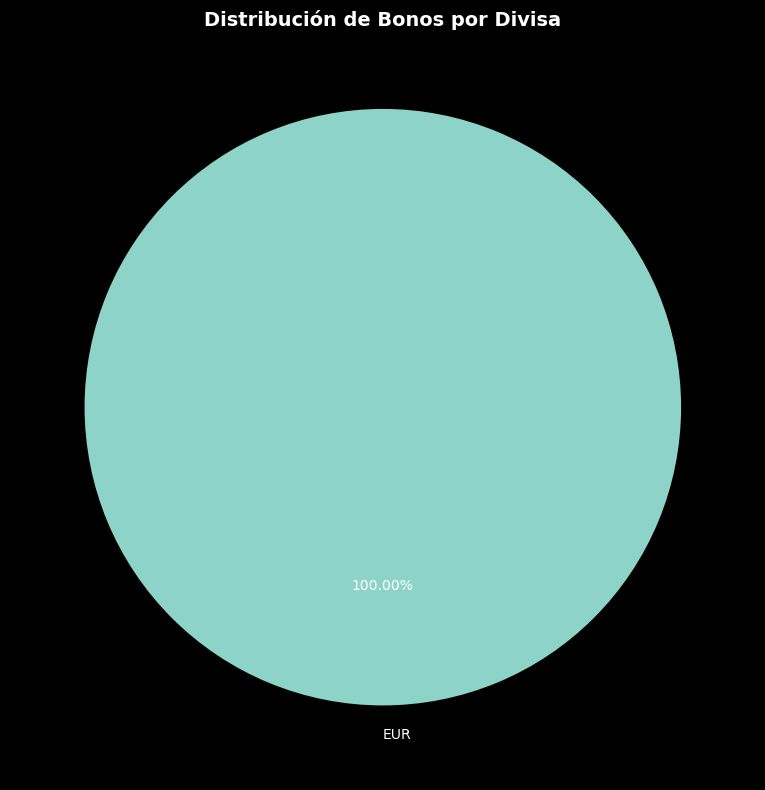

In [6]:

# ANÁLISIS DE DIVISAS:
# Analizamos la distribución de bonos por divisa (moneda)
# Esto es importante porque afecta al riesgo cambiario de la cartera


# Contamos cuántos bonos hay de cada divisa
divisas = universo['Ccy'].value_counts()

print("Distribución de divisas:")
print(divisas)
print(f"\nTotal de divisas diferentes: {len(divisas)}")
print(f"\nPorcentaje por divisa:")
for ccy, count in divisas.items():
    pct = (count / len(universo)) * 100
    print(f"{ccy}: {pct:.2f}%")

# 
# VISUALIZACIÓN DE DIVISAS:
# Creamos un pie chart para visualizar mejor la distribución

# Ajustamos el tamaño a (8, 8) para asegurar que el círculo no se vea ovalado
fig, ax = plt.subplots(figsize=(8, 8))

divisas.plot(
    kind='pie', 
    ax=ax, 
    autopct='%1.2f%%',    # Muestra el porcentaje con 2 decimales
    startangle=90,        # Empieza a rotar desde la parte superior (12 en punto)
    shadow=False,         # (Opcional) Sombra para efecto 3D
    legend=False          # Ocultamos la leyenda si las etiquetas son claras
)

ax.set_ylabel('')  # Eliminamos la etiqueta automática del eje Y que pone pandas
ax.set_title('Distribución de Bonos por Divisa', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

Se puede observar claramente como el 100% de los bonos tienen como divisa el Euro.

#### <font color=#808080>Tipos de bono</font>

In [7]:
# ANÁLISIS DE TIPOS DE BONO:
# Analizamos diferentes características de los bonos que afectan a su
# valoración y riesgo: tipo de cupón, prelación, opcionalidad y perpetuos
#


# 1. TIPO DE CUPÓN (FIJO VS VARIABLE):
# Los bonos pueden tener cupón fijo (tasa constante) o variable (tasa flotante)
# Esto afecta a la sensibilidad a cambios en tipos de interés

tipo_cupon = universo['Coupon Type'].value_counts()
print("Distribución por tipo de cupón:")
print(tipo_cupon)
print(f"\nPorcentaje:")
for tipo, count in tipo_cupon.items():
    pct = (count / len(universo)) * 100
    print(f"{tipo}: {pct:.2f}%")


# 2. PRELACIÓN (SENIORITY):
# La prelación determina el orden de pago en caso de quiebra del emisor
# Senior tiene prioridad sobre Subordinated

prelacion = universo['Seniority'].value_counts()
print(f"\n\nDistribución por prelación:")
print(prelacion)
print(f"\nPorcentaje:")
for sen, count in prelacion.items():
    pct = (count / len(universo)) * 100
    print(f"{sen}: {pct:.2f}%")


# 3. OPCIONALIDAD (CALLABLE):
# Los bonos callable pueden ser recomprados por el emisor antes del vencimiento
# Esto introduce riesgo de reinversión para el inversor

callable_bonds = universo['Callable'].value_counts()
print(f"\n\nBonos con opción de compra (Callable):")
print(callable_bonds)
print(f"\nPorcentaje:")
for call, count in callable_bonds.items():
    pct = (count / len(universo)) * 100
    print(f"{call}: {pct:.2f}%")


# 4. BONOS PERPETUOS (SIN FECHA DE VENCIMIENTO):
# Los bonos perpetuos no tienen fecha de vencimiento fija
# Para valoración, usaremos la próxima fecha call como vencimiento

perpetuos = universo[universo['Maturity'].isna()]
print(f"Bonos perpetuos encontrados: {len(perpetuos)}")


Distribución por tipo de cupón:
Coupon Type
FIXED       1910
VARIABLE     345
Name: count, dtype: int64

Porcentaje:
FIXED: 84.70%
VARIABLE: 15.30%


Distribución por prelación:
Seniority
Sr Unsecured        1675
Sr Non Preferred     190
Sr Preferred         179
Subordinated         153
Jr Subordinated       25
Secured               20
1st lien              13
Name: count, dtype: int64

Porcentaje:
Sr Unsecured: 74.28%
Sr Non Preferred: 8.43%
Sr Preferred: 7.94%
Subordinated: 6.78%
Jr Subordinated: 1.11%
Secured: 0.89%
1st lien: 0.58%


Bonos con opción de compra (Callable):
Callable
Y    1640
N     615
Name: count, dtype: int64

Porcentaje:
Y: 72.73%
N: 27.27%
Bonos perpetuos encontrados: 19


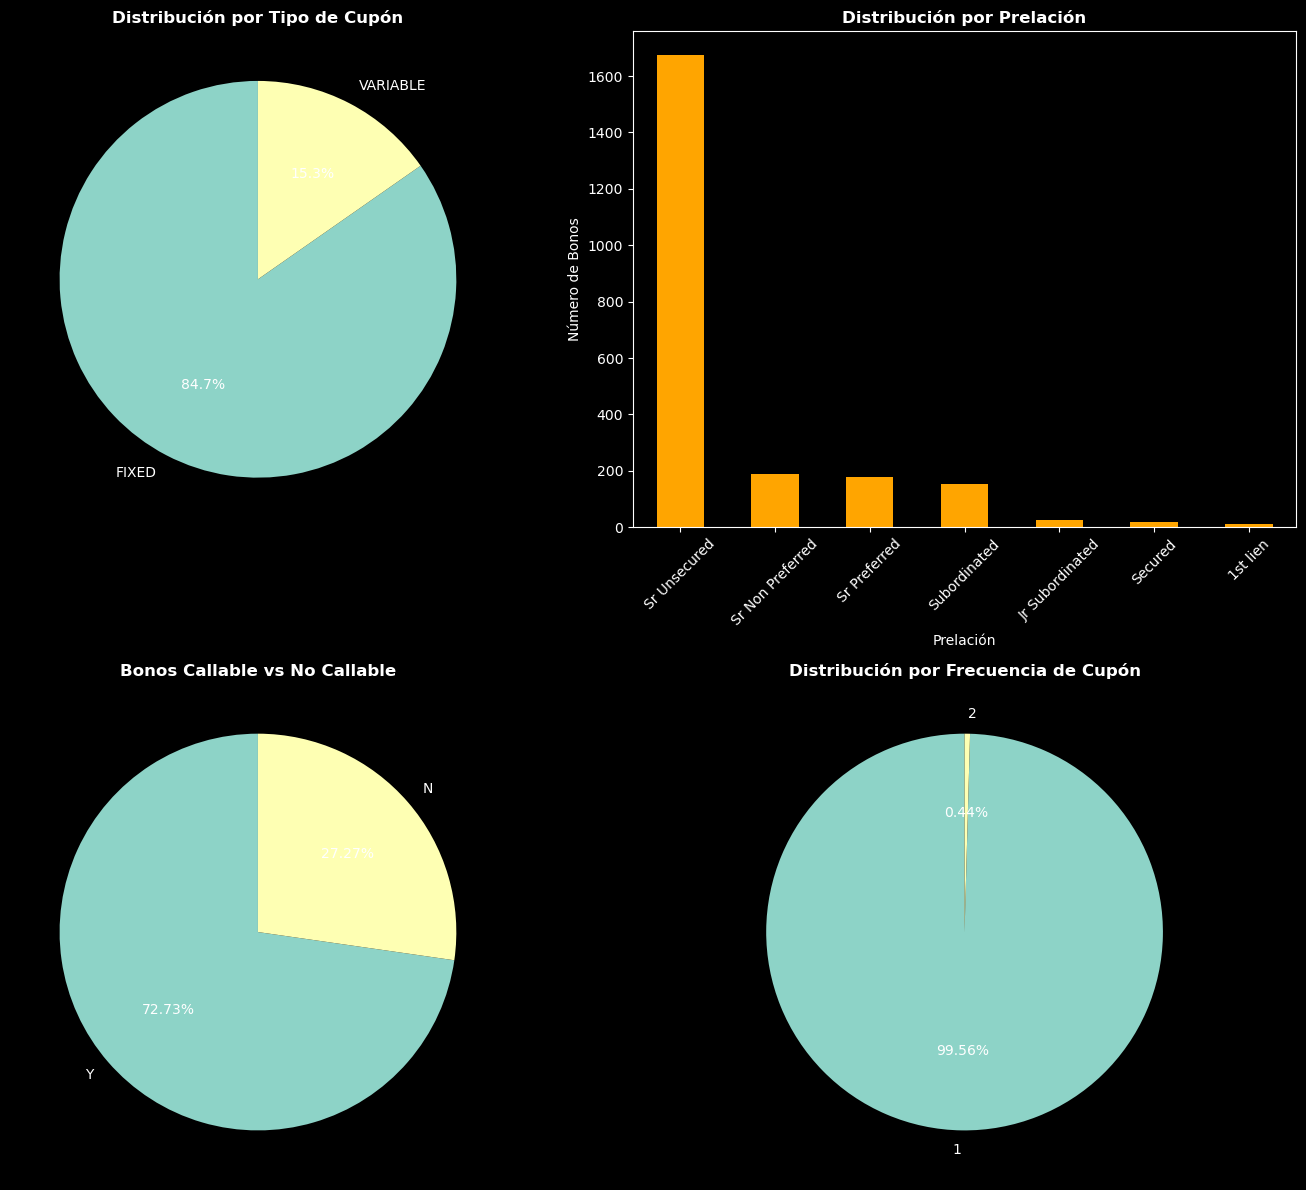

In [9]:
# VISUALIZACIONES DE TIPOS DE BONO:
# Creamos un panel de 4 gráficos para visualizar todas las características
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# --- Gráfico 1: Tipo de cupón ---
tipo_cupon.plot(
    kind='pie', 
    ax=axes[0, 0], 
    autopct='%1.1f%%', 
    startangle=90, 
    ylabel='' # Ocultar etiqueta del eje Y
)
axes[0, 0].set_title('Distribución por Tipo de Cupón', fontsize=12, fontweight='bold')

# --- Gráfico 2: Prelación ---
prelacion.plot(kind='bar', ax=axes[0, 1], color='orange')
axes[0, 1].set_title('Distribución por Prelación', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Prelación')
axes[0, 1].set_ylabel('Número de Bonos')
axes[0, 1].tick_params(axis='x', rotation=45)

# --- Gráfico 3: Callable ---
callable_bonds.plot(
    kind='pie', 
    ax=axes[1, 0], 
    autopct='%1.2f%%', 
    startangle=90, 
    ylabel='',
    

)
axes[1, 0].set_title('Bonos Callable vs No Callable', fontsize=12, fontweight='bold')

# --- Gráfico 4: Frecuencia de cupón ---
freq_cupon = universo['Coupon Frequency'].value_counts()
freq_cupon.plot(
    kind='pie', 
    ax=axes[1, 1], 
    autopct='%1.2f%%', 
    startangle=90, 
    ylabel=''
)
axes[1, 1].set_title('Distribución por Frecuencia de Cupón', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


#### <font color=#808080>Sectores y emisores</font>

Distribución por sectores:
Industry Sector
Financial                 1012
Consumer, Non-cyclical     400
Industrial                 211
Communications             175
Consumer, Cyclical         171
Utilities                  150
Basic Materials             72
Technology                  51
Energy                      13
Name: count, dtype: int64

Total de sectores diferentes: 9


Total de emisores diferentes: 613

Top 10 emisores por número de emisiones:
Issuer
BANQUE FED CRED MUTUEL     33
BNP PARIBAS                27
VONOVIA SE                 23
ORANGE SA                  23
BPCE SA                    23
SOCIETE GENERALE           21
VOLKSWAGEN INTL FIN NV     21
NESTLE FINANCE INTL LTD    20
CREDIT AGRICOLE SA         19
UNIBAIL-RODAMCO-WESTFLD    19
Name: count, dtype: int64


Concentración de los top 10 emisores: 10.16%
Concentración del top emisor: 1.46%


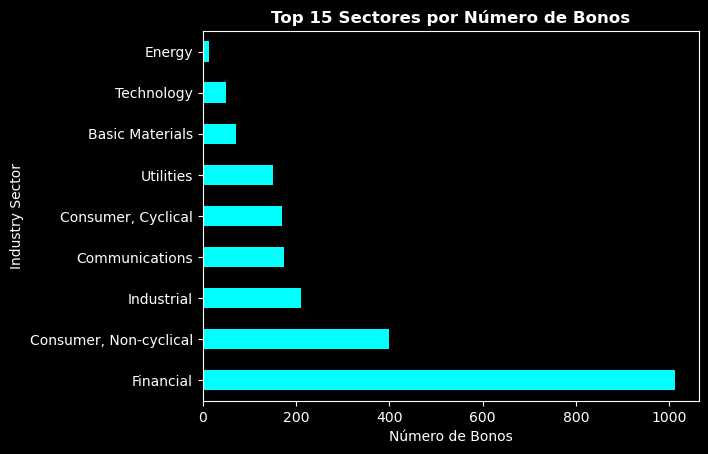

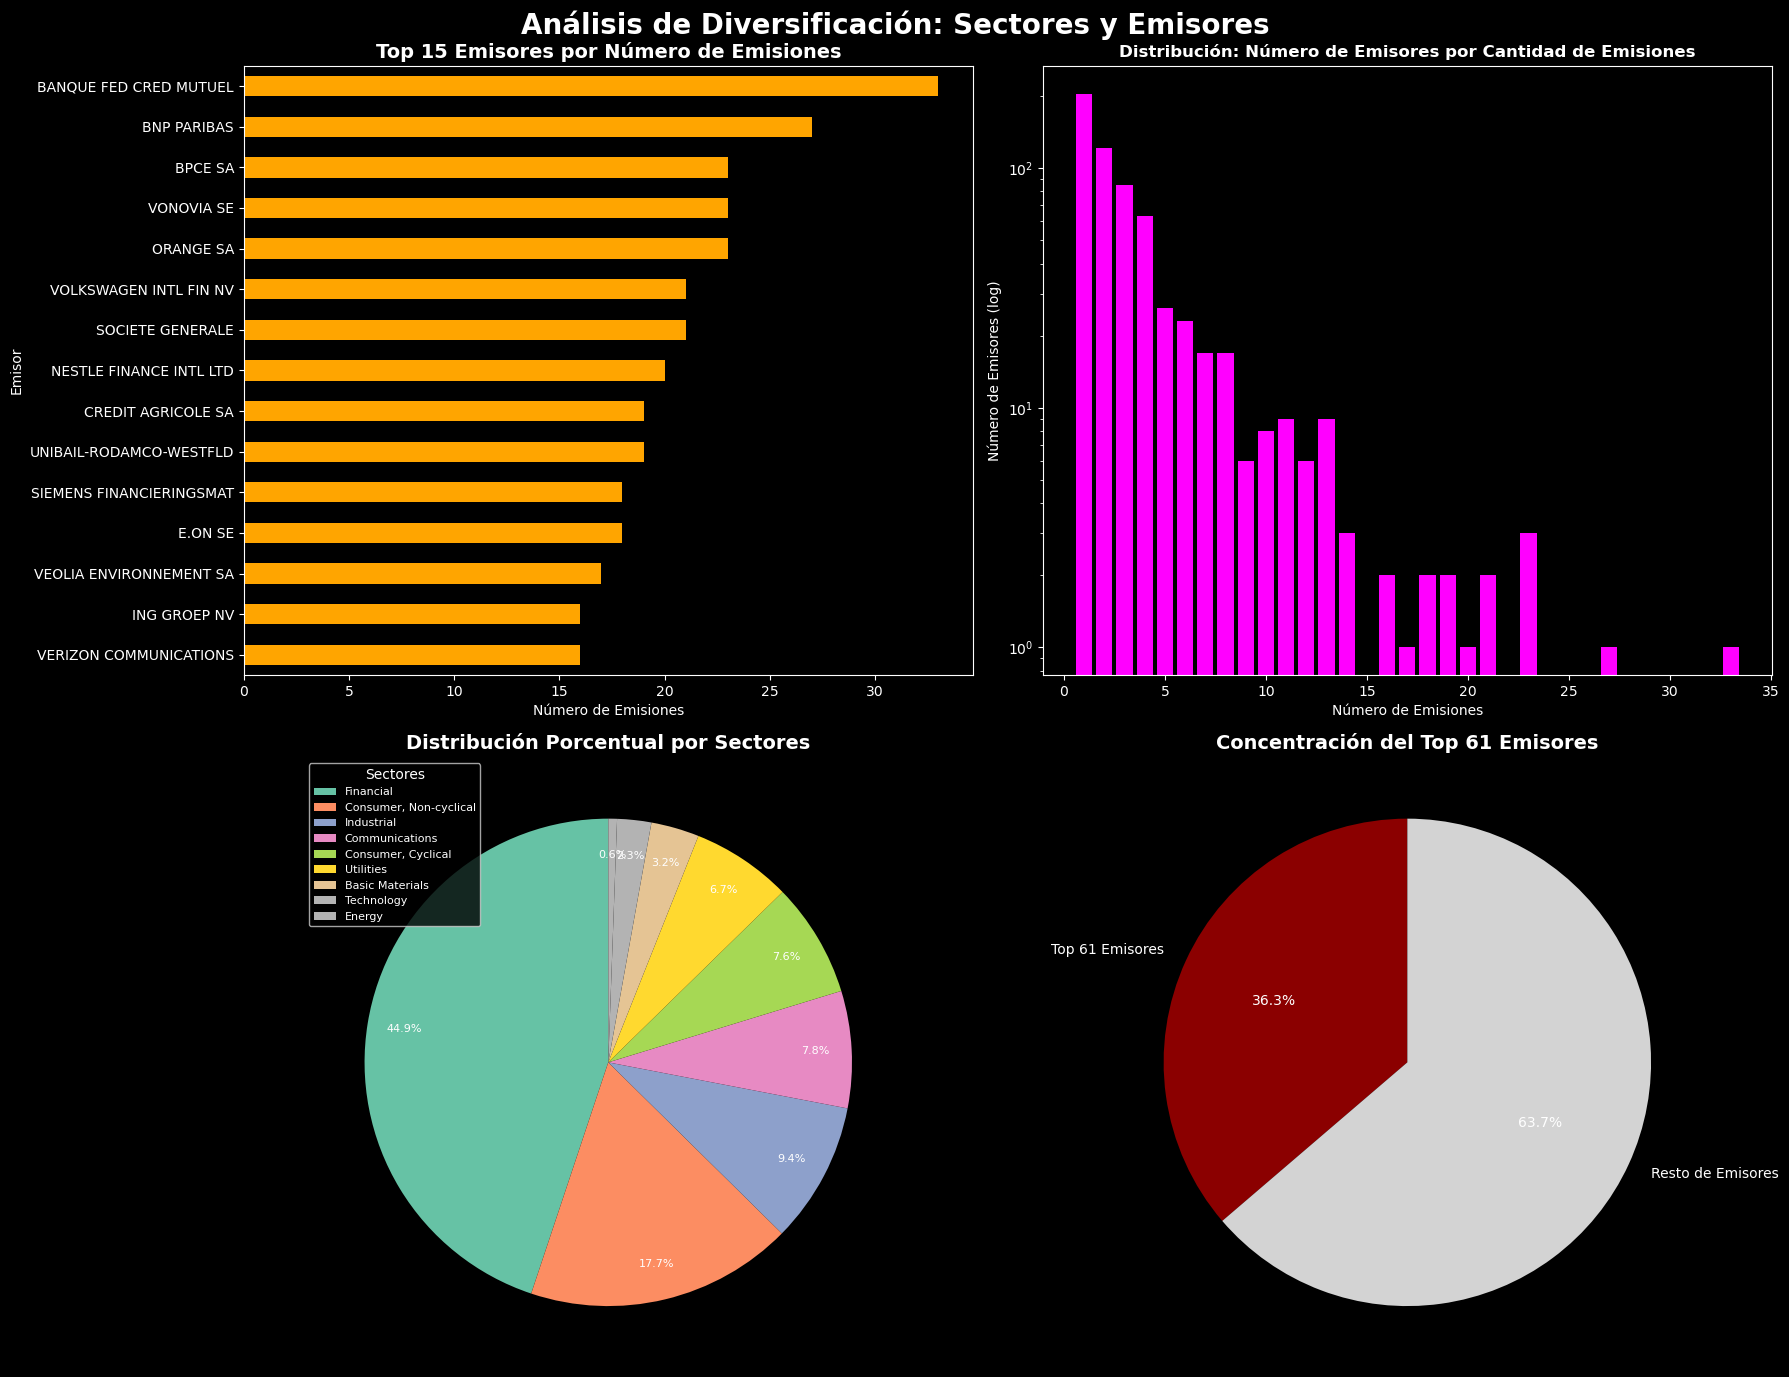


ANÁLISIS DE DIVERSIFICACIÓN DE CARTERA EQUIPONDERADA

1. DIVERSIFICACIÓN HORIZONTAL = EXCELENTE
• 2,255 bonos = riesgo casi eliminado
• 613 emisores con top 1 solo 1.46% = protección contra defaults
• Top 10 emisores: 10.16% = baja concentración por emisor
• Comparable a índices profesionales (iBoxx ~2,500 bonos)

✓ EXCELENTE diversificación horizontal: muchos jugadores (bonos) de diferentes equipos (emisores)

2. DIVERSIFICACIÓN VERTICAL = PREOCUPANTE
• 44.9% en sector financiero vs ~30% en benchmarks (+14.9pp sobreexpuesto)
• HHI sectorial: 2594 (>2,500 = alta concentración)

 RIESGO SISTÉMICO BANCARIO:
   - Bancos interconectados (se prestan entre sí)

• Sectores defensivos bajos: Energy 0.6%, Tech 2.3%, Utilities 6.7%

 PREOCUPANTE diversificación vertical: demasiados juegan en la misma posición (sector financiero)

5. RECOMENDACIONES
• Limitar financiero a ≤30%
• Aumentar defensivos: Energy 5%, Tech 8%, Utilities 10%

CONCLUSIÓN GENERAL:
EXCELENTE diversificación horizontal (bono

In [ ]:
# ANÁLISIS DE SECTORES Y EMISORES:
# Analizamos la diversificación de la cartera por sector industrial y emisor
# Una cartera bien diversificada reduce el riesgo de concentración


# 1. DISTRIBUCIÓN POR SECTORES:
# Contamos cuántos bonos hay en cada sector industrial

sectores = universo['Industry Sector'].value_counts()
print("Distribución por sectores:")
print(sectores)
print(f"\nTotal de sectores diferentes: {len(sectores)}")


# 2. DISTRIBUCIÓN POR EMISORES:
# Contamos cuántas emisiones tiene cada emisor
# Esto nos ayuda a identificar concentración por emisor


emisores = universo['Issuer'].value_counts()
print(f"\n\nTotal de emisores diferentes: {len(emisores)}")
print(f"\nTop 10 emisores por número de emisiones:")
print(emisores.head(10))


# 3. ANÁLISIS DE CONCENTRACIÓN:
# Calculamos la concentración de la cartera si fuera equiponderada
# Una alta concentración aumenta el riesgo de la cartera


peso_por_emisor = emisores / len(universo) * 100
concentracion_top10 = peso_por_emisor.head(10).sum()
print(f"\n\nConcentración de los top 10 emisores: {concentracion_top10:.2f}%")
print(f"Concentración del top emisor: {peso_por_emisor.iloc[0]:.2f}%")

# ============================================================================
# VISUALIZACIONES DE SECTORES Y EMISORES
# ============================================================================
# Creamos un panel de 4 gráficos para analizar la diversificación
# ============================================================================


fig= figsize=(16, 12)
# Sectores - Top 15
sectores.head(15).plot(kind='barh', color='cyan')
plt.title('Top 15 Sectores por Número de Bonos', fontsize=12, fontweight='bold')
plt.xlabel('Número de Bonos')


fig, axes = plt.subplots(2, 2, figsize=(18, 14))
plt.suptitle('Análisis de Diversificación: Sectores y Emisores', fontsize=20, fontweight='bold')

# --- 1. Top 15 Emisores (Mantenido - Barras Horizontales) ---
emisores.head(15).sort_values(ascending=True).plot(
    kind='barh', 
    ax=axes[0, 0], 
    color='orange'
)
axes[0, 0].set_title('Top 15 Emisores por Número de Emisiones', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Número de Emisiones')
axes[0, 0].set_ylabel('Emisor')


# Distribución de número de emisiones por emisor
num_emisiones_por_emisor = emisores.value_counts().sort_index()
axes[0, 1].bar(num_emisiones_por_emisor.index, num_emisiones_por_emisor.values, color='magenta')
axes[0, 1].set_title('Distribución: Número de Emisores por Cantidad de Emisiones', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Número de Emisiones')
axes[0, 1].set_ylabel('Número de Emisores (log)')
axes[0, 1].set_yscale('log')

# --- 3. Distribución Porcentual por Sectores (NUEVO - Gráfico Circular) ---
# Ajustamos el gráfico para evitar solapamiento de etiquetas
wedges, texts, autotexts = axes[1, 0].pie(
    sectores.values,
    labels=None,  # No mostramos etiquetas en el gráfico para evitar solapamiento
    autopct='%1.1f%%',
    startangle=90,
    colors=plt.cm.Set2(range(len(sectores))),
    pctdistance=0.85,
    textprops={'fontsize': 8}
)

# Añadimos leyenda fuera del gráfico para evitar solapamiento
axes[1, 0].legend(
    wedges, 
    sectores.index, 
    title="Sectores",
    loc="best",
    fontsize=8,
    frameon=True
)
axes[1, 0].set_title('Distribución Porcentual por Sectores', fontsize=14, fontweight='bold')


# --- 4. Concentración del Top 10% Emisores (NUEVO - Gráfico Circular) ---
# 3. Concentración para el Gráfico Circular
# Calcular el 10% del total de emisores
total_emisores = len(emisores)
num_emisores_top10pct = max(1, round(total_emisores * 0.10))

# Sumar las emisiones del Top 10% de emisores
top_emisores_count = emisores.head(num_emisores_top10pct).sum()
rest_emisores_count = len(universo) - top_emisores_count

# Crear la serie para el gráfico circular de concentración
concentracion_data = pd.Series(
    [top_emisores_count, rest_emisores_count], 
    index=[f'Top {num_emisores_top10pct} Emisores', 'Resto de Emisores']
)
concentracion_data.plot(
    kind='pie', 
    ax=axes[1, 1], 
    autopct='%1.1f%%', 
    startangle=90, 
    ylabel='', 
    colors=['darkred', 'lightgray']
)
axes[1, 1].set_title(f'Concentración del Top {num_emisores_top10pct} Emisores', fontsize=14, fontweight='bold')


plt.tight_layout()
plt.show()

# ============================================================================
# ANÁLISIS DE DIVERSIFICACIÓN HORIZONTAL VS VERTICAL
# ============================================================================
# Calculamos HHI sectorial y porcentajes de distribución
# ============================================================================

# Cálculo de HHI (Herfindahl-Hirschman Index) sectorial
peso_sectorial = sectores / len(universo) * 100
hhi_sectorial = (peso_sectorial ** 2).sum()

# Distribución porcentual por sector
distribucion_sectorial = peso_sectorial.sort_values(ascending=False)
pct_financiero = distribucion_sectorial.get('Financial', 0)
pct_consumer_nc = distribucion_sectorial.get('Consumer, Non-cyclical', 0)
pct_industrial = distribucion_sectorial.get('Industrial', 0)
pct_energy = distribucion_sectorial.get('Energy', 0)
pct_tech = distribucion_sectorial.get('Technology', 0)
pct_utilities = distribucion_sectorial.get('Utilities', 0)

# ============================================================================
# CONCLUSIÓN SOBRE DIVERSIFICACIÓN
# ============================================================================
# Análisis completo de diversificación horizontal (bonos/emisores) 
# vs vertical (sectores)
# ============================================================================

print(f"\n{'='*80}")
print("ANÁLISIS DE DIVERSIFICACIÓN DE CARTERA EQUIPONDERADA")
print(f"{'='*80}")

print(f"\n{'='*80}")
print("1. DIVERSIFICACIÓN HORIZONTAL = EXCELENTE")
print(f"{'='*80}")
print(f"• 2,255 bonos = riesgo casi eliminado")
print(f"• 613 emisores con top 1 solo {peso_por_emisor.iloc[0]:.2f}% = protección contra defaults")
print(f"• Top 10 emisores: {concentracion_top10:.2f}% = baja concentración por emisor")
print(f"• Comparable a índices profesionales (iBoxx ~2,500 bonos)")
print(f"\n✓ EXCELENTE diversificación horizontal: muchos jugadores (bonos) de diferentes equipos (emisores)")

print(f"\n{'='*80}")
print("2. DIVERSIFICACIÓN VERTICAL = PREOCUPANTE")
print(f"{'='*80}")
print(f"• {pct_financiero:.1f}% en sector financiero vs ~30% en benchmarks (+{pct_financiero-30:.1f}pp sobreexpuesto)")
print(f"• HHI sectorial: {hhi_sectorial:.0f} (>2,500 = alta concentración)")
print(f"\n RIESGO SISTÉMICO BANCARIO:")
print(f"   - Bancos interconectados (se prestan entre sí)")
print(f"\n• Sectores defensivos bajos: Energy {pct_energy:.1f}%, Tech {pct_tech:.1f}%, Utilities {pct_utilities:.1f}%")
print(f"\n PREOCUPANTE diversificación vertical: demasiados juegan en la misma posición (sector financiero)")

print(f"\n{'='*80}")
print("5. RECOMENDACIONES")
print(f"{'='*80}")
print("• Limitar financiero a ≤30%")
print("• Aumentar defensivos: Energy 5%, Tech 8%, Utilities 10%")

print(f"\n{'='*80}")
print("CONCLUSIÓN GENERAL:")
print(f"{'='*80}")
print("EXCELENTE diversificación horizontal (bonos/emisores) pero")
print("PREOCUPANTE diversificación vertical (sectores) por alta")
print(f"concentración en financiero ({pct_financiero:.1f}%) y su riesgo sistémico")
print(f"{'='*80}")


Se observa que el 44,9% de los bonos tienen como emisor empresas del sector financiero. Provocando una gran dependencia de este sector y un riesgo sistémico. También cabe notar que hay una cierta diversificación entre los emsisores más numerosos ya que los diez emisores con mas bonos tienen el 10% de la cartera. Al mismo tiempo el top 10% de emisores solo abarca el 36% de los bonos de la cartera.

#### <font color=#808080>Ratings (Riesgo de crédito)</font>

Distribución de ratings:
Rating
A       230
A+      185
A-      374
AA       22
AA+       7
AA-     100
AAA       4
BB+      10
BBB     310
BBB+    439
BBB-    184
NR      389
Name: count, dtype: int64

Total de ratings diferentes: 12

Porcentaje por rating:
A: 10.20%
A+: 8.20%
A-: 16.59%
AA: 0.98%
AA+: 0.31%
AA-: 4.43%
AAA: 0.18%
BB+: 0.44%
BBB: 13.75%
BBB+: 19.47%
BBB-: 8.16%
NR: 17.25%


Clasificación por categoría de riesgo:
Rating_Class
Investment Grade    1855
No Rating            390
High Yield            10
Name: count, dtype: int64

Porcentaje:
Investment Grade: 82.26%
No Rating: 17.29%
High Yield: 0.44%


Análisis de Probabilidad de Default (PD 1YR):
Valores nulos: 24
Estadísticas descriptivas:
count    2.231000e+03
mean     3.616280e-03
std      8.372564e-03
min      2.944640e-12
25%      1.502910e-05
50%      1.253650e-04
75%      1.270443e-03
max      6.312192e-02
Name: PD 1YR, dtype: float64


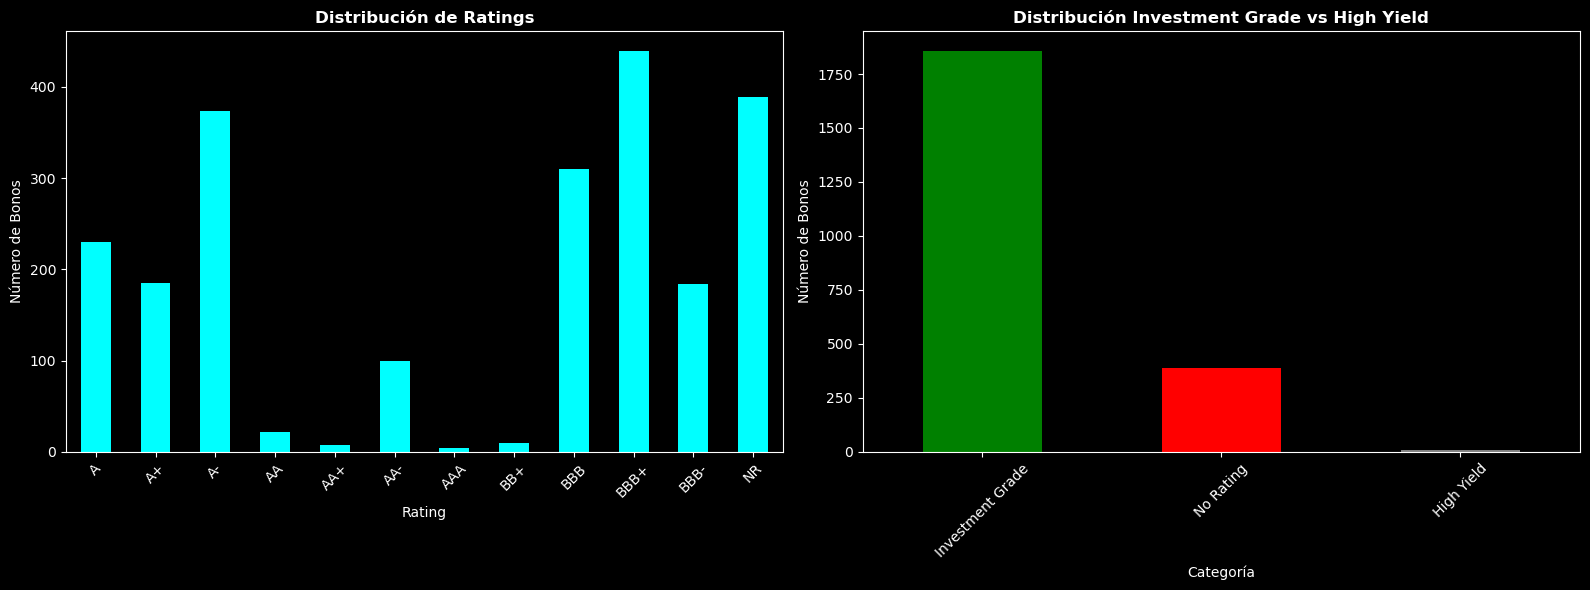

In [ ]:
# ANÁLISIS DE RATINGS (RIESGO DE CRÉDITO):
# El rating es una medida clave del riesgo crediticio de cada bono
# Analizamos la distribución de ratings y los clasificamos en categorías

# DISTRIBUCIÓN DE RATINGS:
# Contamos cuántos bonos hay de cada rating específico

ratings = universo['Rating'].value_counts().sort_index()
print("Distribución de ratings:")
print(ratings)
print(f"\nTotal de ratings diferentes: {len(ratings)}")
print(f"\nPorcentaje por rating:")
for rating, count in ratings.items():
    pct = (count / len(universo)) * 100
    print(f"{rating}: {pct:.2f}%")

# CLASIFICACIÓN INVESTMENT GRADE VS HIGH YIELD:
# Definimos las categorías de ratings:
# - Investment Grade: AAA hasta BBB- (menor riesgo crediticio)
# - High Yield: BB+ hasta D (mayor riesgo crediticio)

investment_grade = ['AAA', 'AA+', 'AA', 'AA-', 'A+', 'A', 'A-', 'BBB+', 'BBB', 'BBB-']
high_yield = ['BB+', 'BB', 'BB-', 'B+', 'B', 'B-', 'CCC+', 'CCC', 'CCC-', 'CC', 'C', 'D']


# FUNCIÓN PARA CLASIFICAR RATINGS:
# Esta función clasifica cada rating en Investment Grade, High Yield o No Rating

def clasificar_rating(rating):
    if pd.isna(rating) or rating == '' or rating == 'NR':
        return 'No Rating'
    rating_clean = str(rating).strip()
    if rating_clean in investment_grade:
        return 'Investment Grade'
    elif rating_clean in high_yield:
        return 'High Yield'
    else:
        return 'No Rating'

# Aplicamos la clasificación a todos los bonos
universo['Rating_Class'] = universo['Rating'].apply(clasificar_rating)
rating_class = universo['Rating_Class'].value_counts()

print(f"\n\nClasificación por categoría de riesgo:")
print(rating_class)
print(f"\nPorcentaje:")
for clase, count in rating_class.items():
    pct = (count / len(universo)) * 100
    print(f"{clase}: {pct:.2f}%")

# ANÁLISIS DE PD (PROBABILIDAD DE DEFAULT A 1 AÑO):
# La PD es una medida cuantitativa del riesgo de impago
# Valores más altos indican mayor probabilidad de default

print(f"\n\nAnálisis de Probabilidad de Default (PD 1YR):")
print(f"Valores nulos: {universo['PD 1YR'].isna().sum()}")
print(f"Estadísticas descriptivas:")
print(universo['PD 1YR'].describe())

# ============================================================================
# VISUALIZACIONES DE RATINGS Y RIESGO DE CRÉDITO
# ============================================================================
# Creamos un panel de 4 gráficos para analizar el riesgo crediticio
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6)) # figsize ajustado para mejor aspecto horizontal

# Distribución de ratings
# Indexación corregida: axes[0]
ratings.plot(kind='bar', ax=axes[0], color='cyan')
axes[0].set_title('Distribución de Ratings', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Número de Bonos')
axes[0].tick_params(axis='x', rotation=45)

# Clasificación IG vs HY
# Indexación corregida: axes[1]
rating_class.plot(kind='bar', ax=axes[1], color=['green', 'red', 'gray'])
axes[1].set_title('Distribución Investment Grade vs High Yield', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Categoría')
axes[1].set_ylabel('Número de Bonos')
axes[1].tick_params(axis='x', rotation=45)

# Ajusta automáticamente el espaciado para que los elementos no se superpongan
plt.tight_layout()

#### <font color=#808080>Riesgo de liquidez - Horquillas y nominal vivo</font>

Análisis de Horquillas (Bid-Ask Spread):
Valores nulos en Bid Price: 0
Valores nulos en Ask Price: 0

Estadísticas del spread absoluto:
count    2255.000000
mean        0.327213
std         0.165488
min         0.064000
25%         0.201000
50%         0.294000
75%         0.418000
max         2.255000
Name: Bid_Ask_Spread, dtype: float64

Estadísticas del spread porcentual:
count    2255.000000
mean        0.346703
std         0.198603
min         0.065484
25%         0.203803
50%         0.301650
75%         0.433251
max         2.521074
Name: Bid_Ask_Spread_Pct, dtype: float64


Análisis de Nominal Vivo (Outstanding Amount):
Valores nulos: 0
Estadísticas descriptivas (en millones):
count    2255.000000
mean      744.928859
std       309.513822
min       249.997000
25%       500.000000
50%       700.000000
75%      1000.000000
max      3000.000000
Name: Outstanding Amount, dtype: float64


Distribución por tamaño de emisión:
Tamaño_Emision
500M - 1B    1549
1B - 2B       556
< 500M  

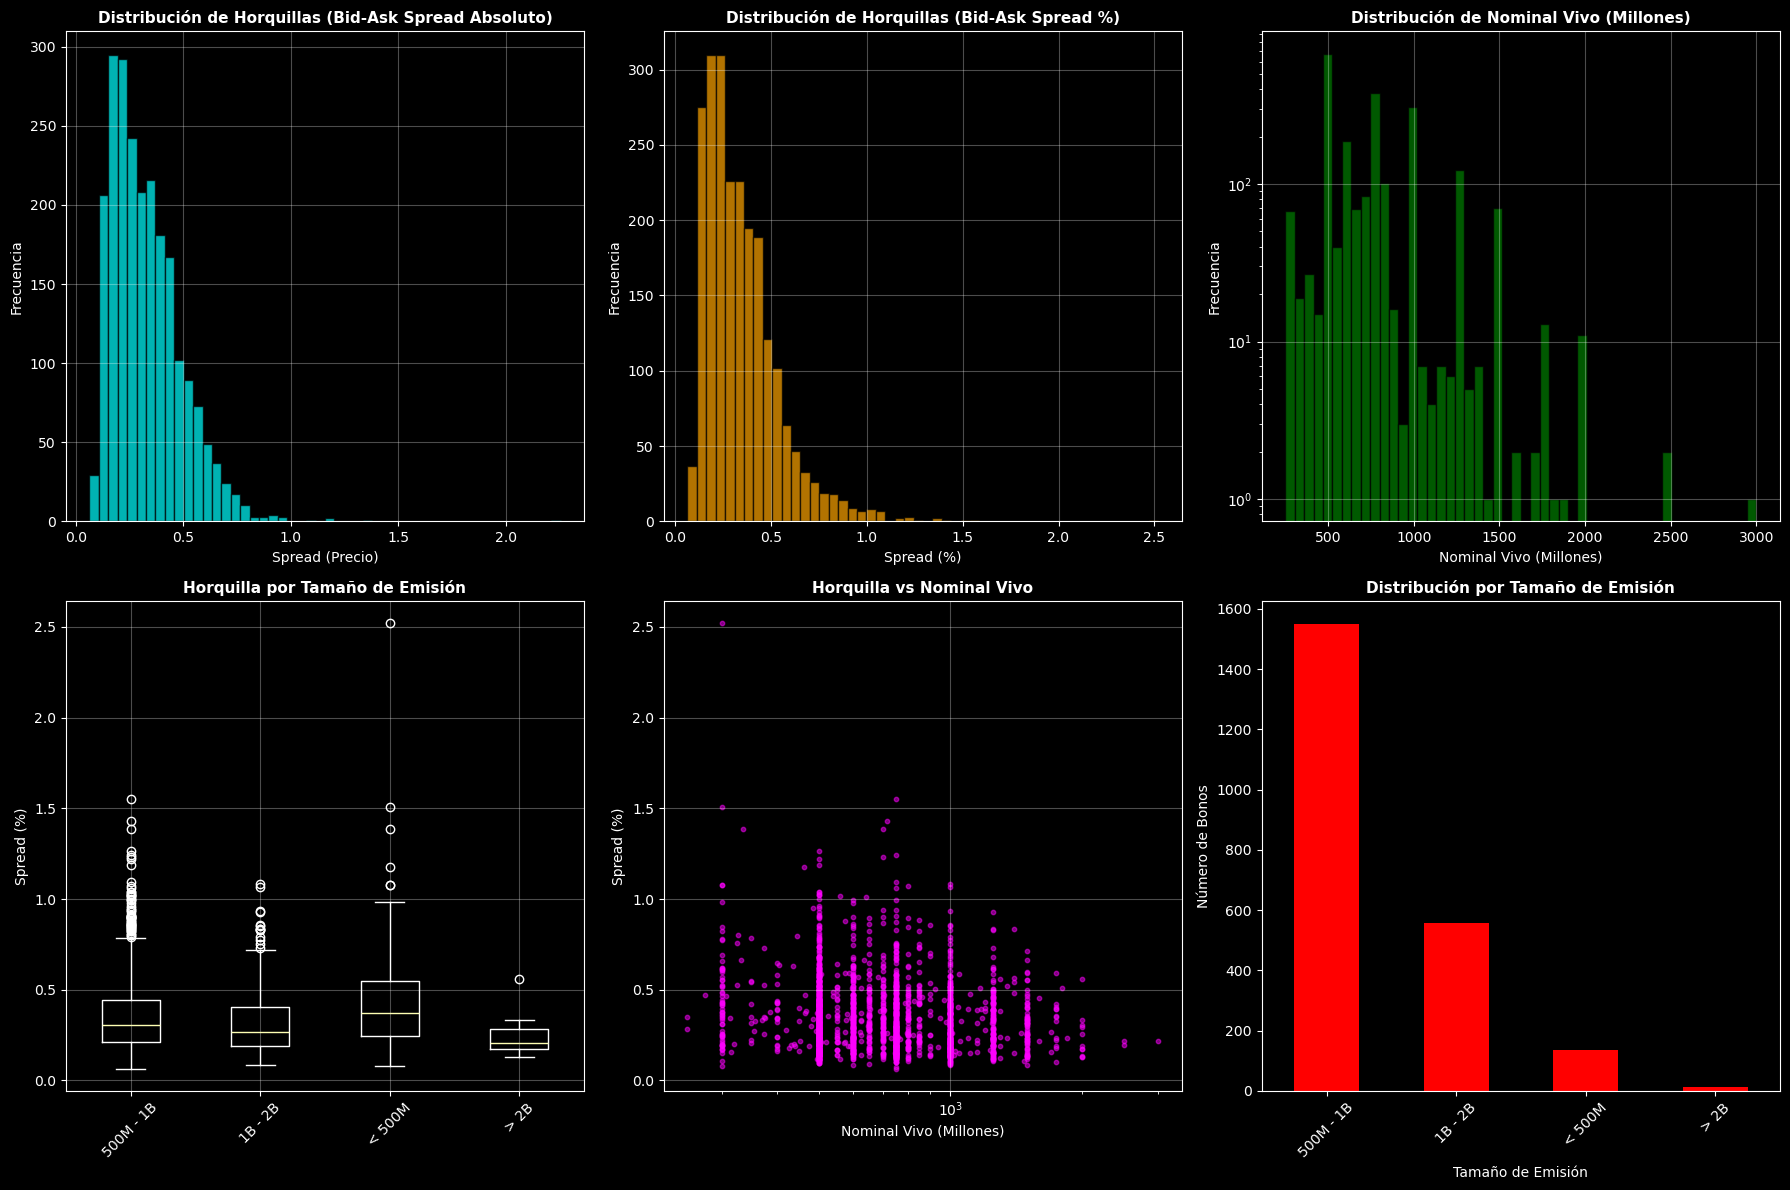


CONCLUSIONES SOBRE RIESGO DE LIQUIDEZ:
- Horquilla media: 0.347%
- Horquilla mediana: 0.302%
- Bonos con horquilla > 1%: 27 (1.20%)
- Bonos con emisión < 500M: 136 (6.03%)
- Bonos con emisión >= 500M: 2119 (93.97%)


In [ ]:
# ============================================================================
# ANÁLISIS DE RIESGO DE LIQUIDEZ - HORQUILLAS Y NOMINAL VIVO
# ============================================================================
# El riesgo de liquidez mide la facilidad para comprar/vender un bono
# Analizamos horquillas bid-ask y tamaño de emisión (nominal vivo)
# ============================================================================

# ============================================================================
# 1. CÁLCULO DE HORQUILLAS (BID-ASK SPREAD)
# ============================================================================
# La horquilla es la diferencia entre precio de compra (Ask) y venta (Bid)
# Horquillas más amplias indican menor liquidez
# ============================================================================

universo['Bid_Ask_Spread'] = universo['Ask Price'] - universo['Bid Price']
universo['Bid_Ask_Spread_Pct'] = (universo['Bid_Ask_Spread'] / universo['Price']) * 100

print("Análisis de Horquillas (Bid-Ask Spread):")
print(f"Valores nulos en Bid Price: {universo['Bid Price'].isna().sum()}")
print(f"Valores nulos en Ask Price: {universo['Ask Price'].isna().sum()}")
print(f"\nEstadísticas del spread absoluto:")
print(universo['Bid_Ask_Spread'].describe())
print(f"\nEstadísticas del spread porcentual:")
print(universo['Bid_Ask_Spread_Pct'].describe())

# ============================================================================
# EXPLICACIÓN DE LECTURA DE LAS ESTADÍSTICAS DE SPREAD
# ============================================================================
# 
# SPREAD ABSOLUTO (Bid_Ask_Spread):
# - Representa la diferencia en unidades monetarias (€) entre el precio 
#   de compra (Ask) y el precio de venta (Bid)
# - Ejemplo: Si Ask = 100.50€ y Bid = 100.30€, el spread absoluto = 0.20€
# - Interpretación:
#   * Spread bajo (< 0.30€): Alta liquidez, fácil comprar/vender
#   * Spread medio (0.30-0.50€): Liquidez moderada
#   * Spread alto (> 0.50€): Baja liquidez, mayor coste de transacción
#
# SPREAD PORCENTUAL (Bid_Ask_Spread_Pct):
# - Representa el spread absoluto como porcentaje del precio del bono
# - Fórmula: (Spread Absoluto / Precio del Bono) × 100
# - Ejemplo: Si spread absoluto = 0.20€ y precio = 100€, spread % = 0.20%
# - Interpretación:
#   * Spread < 0.25%: Excelente liquidez (bonos muy líquidos)
#   * Spread 0.25-0.50%: Buena liquidez (bonos estándar)
#   * Spread 0.50-1.00%: Liquidez moderada (riesgo de liquidez medio)
#   * Spread > 1.00%: Baja liquidez (riesgo elevado, difícil salir)
#
# ESTADÍSTICAS DESCRIPTIVAS:
# - count: Número de bonos con datos disponibles
# - mean: Promedio de todos los spreads (tendencia central)
# - std: Desviación estándar (variabilidad: mayor = más dispersión)
# - min/25%/50%/75%/max: Percentiles (25%=Q1, 50%=mediana, 75%=Q3)
#   * Mediana (50%): Valor central, resiste a valores extremos
#   * Q3 (75%): 75% de los bonos tienen spread menor o igual
#
# RELACIÓN SPREAD ABSOLUTO vs PORCENTUAL:
# - El spread absoluto es más útil para comparar bonos con precios similares
# - El spread porcentual permite comparar bonos con diferentes precios
# - Un bono con precio alto puede tener spread absoluto alto pero % bajo
#   (ej: precio 150€, spread 0.45€ = 0.30% → aún buena liquidez)
#
# ============================================================================

# ============================================================================
# 2. ANÁLISIS DE NOMINAL VIVO (OUTSTANDING AMOUNT)
# ============================================================================
# El nominal vivo es el tamaño total de la emisión en circulación
# Emisiones más grandes suelen tener mayor liquidez
# ============================================================================

print(f"\n\nAnálisis de Nominal Vivo (Outstanding Amount):")
print(f"Valores nulos: {universo['Outstanding Amount'].isna().sum()}")
print(f"Estadísticas descriptivas (en millones):")
outstanding_millions = universo['Outstanding Amount'] / 1_000_000
print(outstanding_millions.describe())

# ============================================================================
# CLASIFICACIÓN POR TAMAÑO DE EMISIÓN
# ============================================================================
# Clasificamos las emisiones en categorías según su tamaño
# Esto nos ayuda a identificar bonos con mayor o menor liquidez potencial
# ============================================================================

def clasificar_tamano(nominal):
    if pd.isna(nominal):
        return 'Sin dato'
    nominal_mill = nominal / 1_000_000
    if nominal_mill < 500:
        return '< 500M'
    elif nominal_mill < 1000:
        return '500M - 1B'
    elif nominal_mill < 2000:
        return '1B - 2B'
    else:
        return '> 2B'

universo['Tamaño_Emision'] = universo['Outstanding Amount'].apply(clasificar_tamano)
tamano_dist = universo['Tamaño_Emision'].value_counts()
print(f"\n\nDistribución por tamaño de emisión:")
print(tamano_dist)

# ============================================================================
# RELACIÓN ENTRE HORQUILLA Y TAMAÑO DE EMISIÓN
# ============================================================================
# Analizamos la correlación: emisiones más grandes suelen tener menor horquilla
# ============================================================================

print(f"\n\nCorrelación entre horquilla y tamaño de emisión:")
correlacion = universo[['Bid_Ask_Spread_Pct', 'Outstanding Amount']].corr()
print(correlacion)

# ============================================================================
# VISUALIZACIONES DE RIESGO DE LIQUIDEZ
# ============================================================================
# Creamos un panel de 6 gráficos para analizar la liquidez desde diferentes
# perspectivas
# ============================================================================

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Histograma de horquillas absolutas
spread_data = universo['Bid_Ask_Spread'].dropna()
axes[0, 0].hist(spread_data, bins=50, color='cyan', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribución de Horquillas (Bid-Ask Spread Absoluto)', fontsize=11, fontweight='bold')
axes[0, 0].set_xlabel('Spread (Precio)')
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].grid(True, alpha=0.3)

# Histograma de horquillas porcentuales
spread_pct_data = universo['Bid_Ask_Spread_Pct'].dropna()
axes[0, 1].hist(spread_pct_data, bins=50, color='orange', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Distribución de Horquillas (Bid-Ask Spread %)', fontsize=11, fontweight='bold')
axes[0, 1].set_xlabel('Spread (%)')
axes[0, 1].set_ylabel('Frecuencia')
axes[0, 1].grid(True, alpha=0.3)

# Distribución de nominal vivo
outstanding_data = outstanding_millions.dropna()
axes[0, 2].hist(outstanding_data, bins=50, color='green', edgecolor='black', alpha=0.7)
axes[0, 2].set_title('Distribución de Nominal Vivo (Millones)', fontsize=11, fontweight='bold')
axes[0, 2].set_xlabel('Nominal Vivo (Millones)')
axes[0, 2].set_ylabel('Frecuencia')
axes[0, 2].set_yscale('log')
axes[0, 2].grid(True, alpha=0.3)

# Box plot de horquilla por tamaño de emisión
tamano_categories = universo['Tamaño_Emision'].unique()
data_to_plot = [universo[universo['Tamaño_Emision'] == tam]['Bid_Ask_Spread_Pct'].dropna().values 
                for tam in tamano_categories if len(universo[universo['Tamaño_Emision'] == tam]['Bid_Ask_Spread_Pct'].dropna()) > 0]
labels_to_plot = [tam for tam in tamano_categories if len(universo[universo['Tamaño_Emision'] == tam]['Bid_Ask_Spread_Pct'].dropna()) > 0]
if len(data_to_plot) > 0:
    axes[1, 0].boxplot(data_to_plot, tick_labels=labels_to_plot)
    axes[1, 0].set_title('Horquilla por Tamaño de Emisión', fontsize=11, fontweight='bold')
    axes[1, 0].set_ylabel('Spread (%)')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].grid(True, alpha=0.3)

# Scatter: Horquilla vs Nominal Vivo
universo_clean = universo[['Bid_Ask_Spread_Pct', 'Outstanding Amount']].dropna()
if len(universo_clean) > 0:
    axes[1, 1].scatter(universo_clean['Outstanding Amount'] / 1_000_000, 
                       universo_clean['Bid_Ask_Spread_Pct'], 
                       alpha=0.5, color='magenta', s=10)
    axes[1, 1].set_title('Horquilla vs Nominal Vivo', fontsize=11, fontweight='bold')
    axes[1, 1].set_xlabel('Nominal Vivo (Millones)')
    axes[1, 1].set_ylabel('Spread (%)')
    axes[1, 1].set_xscale('log')
    axes[1, 1].grid(True, alpha=0.3)

# Distribución por tamaño de emisión
tamano_dist.plot(kind='bar', ax=axes[1, 2], color='red')
axes[1, 2].set_title('Distribución por Tamaño de Emisión', fontsize=11, fontweight='bold')
axes[1, 2].set_xlabel('Tamaño de Emisión')
axes[1, 2].set_ylabel('Número de Bonos')
axes[1, 2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# ============================================================================
# CONCLUSIONES SOBRE RIESGO DE LIQUIDEZ
# ============================================================================
# Resumen de los principales indicadores de liquidez
# ============================================================================

print(f"\n{'='*60}")
print("CONCLUSIONES SOBRE RIESGO DE LIQUIDEZ:")
print(f"{'='*60}")
print(f"- Horquilla media: {universo['Bid_Ask_Spread_Pct'].mean():.3f}%")
print(f"- Horquilla mediana: {universo['Bid_Ask_Spread_Pct'].median():.3f}%")
print(f"- Bonos con horquilla > 1%: {(universo['Bid_Ask_Spread_Pct'] > 1).sum()} ({(universo['Bid_Ask_Spread_Pct'] > 1).sum()/len(universo)*100:.2f}%)")
print(f"- Bonos con emisión < 500M: {(outstanding_millions < 500).sum()} ({(outstanding_millions < 500).sum()/len(universo)*100:.2f}%)")
print(f"- Bonos con emisión >= 500M: {(outstanding_millions >= 500).sum()} ({(outstanding_millions >= 500).sum()/len(universo)*100:.2f}%)")


#### <font color=#808080>Resto de información</font>

En esta sección, analizamos el resto de ficheros para ver qué información tenemos y, en caso de haber *gaps*, limpiar los datos antes de trabajar con ellos.

##### <font color=#CC6600>Precios bonos universo</font>

In [ ]:
print("ANÁLISIS DE PECIOS HISTORICOS UNIVERSO: ")
precios_universo = pd.read_csv('../data/precios_historicos_universo.csv', sep=';', decimal='.', na_values=['#N/D', ' ', 'NA', 'nan', 'N/A'])
# 1. Renombramos la columna sin nombre
isin_col_name = precios_universo.columns[0]
precios_universo.rename(columns={isin_col_name: 'ISIN'}, inplace=True)

# 2. Ejecutamos MELT
precios_largo = pd.melt(
    precios_universo, 
    id_vars=['ISIN'], 
    var_name='Date', 
    value_name='Price'
)
display
# 3. ANÁLISIS DE FECHAS CORRECTO
precios_largo['Date'] = pd.to_datetime(
    precios_largo['Date'], 
    format='%d/%m/%Y', 
    errors='coerce'
)

print("\n--- Vista Previa del DataFrame Remodelado ---")
print(precios_largo.head())

# 4. DETECCIÓN FINAL DE NULOS (RESPUESTA a tu pregunta)
print(f"\n--- Valores nulos por columna (DETECCIÓN) ---")
print(precios_largo.isnull().sum())

precios_ordenados = precios_largo.sort_values(by=['ISIN', 'Date']).copy()
display(precios_ordenados.head(10))

reportar_gaps_informacion(precios_ordenados, "Precios Varios")

# Eliminamos filas con precios nulos
precios_limpios = precios_ordenados.dropna(subset=['Price']).copy()
print(f"\n Valores nulos tras limpieza de precios:")
print(precios_limpios.isnull().sum())



ANÁLISIS DE PECIOS HISTORICOS UNIVERSO: 

--- Vista Previa del DataFrame Remodelado ---
                ISIN       Date  Price
0  XS0161488498 Corp 2023-10-01    NaN
1  FR0000471930 Corp 2023-10-01    NaN
2  XS0162513211 Corp 2023-10-01    NaN
3  XS0162869076 Corp 2023-10-01    NaN
4  FR0010014845 Corp 2023-10-01    NaN

--- Valores nulos por columna (DETECCIÓN) ---
ISIN          0
Date          0
Price    496681
dtype: int64


,ISIN,Date,Price
804,AT0000A2GH08 Corp,2023-10-01,NaN
3059,AT0000A2GH08 Corp,2023-10-02,89.211
5314,AT0000A2GH08 Corp,2023-10-03,89.185
7569,AT0000A2GH08 Corp,2023-10-04,89.068
9824,AT0000A2GH08 Corp,2023-10-05,89.176
12079,AT0000A2GH08 Corp,2023-10-06,89.137
14334,AT0000A2GH08 Corp,2023-10-07,NaN
16589,AT0000A2GH08 Corp,2023-10-08,NaN
18844,AT0000A2GH08 Corp,2023-10-09,89.442
21099,AT0000A2GH08 Corp,2023-10-10,89.431



 ANÁLISIS DE VALORES NULOS: Precios Varios
Total de filas: 1650660
Columnas con datos faltantes: 1
------------------------------------------------------------
      Tipo de Dato  Cantidad Nulos  Porcentaje (%)
Price      float64          496681           30.09
 ALERTA CRÍTICA: Faltan precios en 496681 bonos.

 Valores nulos tras limpieza de precios:
ISIN     0
Date     0
Price    0
dtype: int64


##### <font color=#CC6600>Otros precios</font>

Para terminar con el análisis de datos, falta lo leído en los ficheros de *"precios_historicos_varios.csv"* y *curvaESTR.csv*.

In [ ]:
# Cargar otros precios (futuros, índices de crédito, benchmark)
print("ANÁLISIS DE OTROS PRECIOS: ")
precios_varios = pd.read_csv('../data/precios_historicos_varios.csv', sep=';', decimal='.')
print(f"\nForma del DataFrame: {precios_varios.shape}")
print(f"\nPrimeras filas:")
reportar_gaps_informacion(precios_varios, "Precios Varios")
# Convertir la primera columna (fecha) a datetime
fecha_col = precios_varios.columns[0]
precios_varios[fecha_col] = pd.to_datetime(precios_varios[fecha_col], format='%d/%m/%Y', errors='coerce')
precios_varios = precios_varios.set_index(fecha_col)

print(f"\nRango de fechas: {precios_varios.index.min()} a {precios_varios.index.max()}")
print(f"Número de fechas: {len(precios_varios)}")

# Separar por tipo de instrumento
print(f"\nInstrumentos disponibles:")
for col in precios_varios.columns:
    print(f"  - {col}")

# Cargar curva ESTR
print("ANÁLISIS DE CURVA ESTR:")

curva_estr = pd.read_csv('../data/curvaESTR.csv', sep=';', decimal='.')
print(f"\nForma del DataFrame: {curva_estr.shape}")
reportar_gaps_informacion(curva_estr, "Curva €STER")

# Convertir fecha a datetime
curva_estr['Date'] = pd.to_datetime(curva_estr['Date'], format='%d/%m/%Y', errors='coerce')
curva_estr = curva_estr.set_index('Date')

print(f"\nRango de fechas: {curva_estr.index.min()} a {curva_estr.index.max()}")
print(f"\nEstadísticas de la curva:")
print(curva_estr.describe())

# Visualización de la curva
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Curva de tipos
axes[0].plot(curva_estr.index, curva_estr['Market Rate'], label='Market Rate', color='cyan', linewidth=2)
axes[0].plot(curva_estr.index, curva_estr['Zero Rate'], label='Zero Rate', color='orange', linewidth=2)
axes[0].set_title('Curva ESTR - Tipos de Interés', fontweight='bold')
axes[0].set_xlabel('Fecha')
axes[0].set_ylabel('Tipo (%)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Factores de descuento
axes[1].plot(curva_estr.index, curva_estr['Discount'], color='green', linewidth=2)
axes[1].set_title('Curva ESTR - Factores de Descuento', fontweight='bold')
axes[1].set_xlabel('Fecha')
axes[1].set_ylabel('Factor de Descuento')
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


ANÁLISIS DE OTROS PRECIOS: 

Forma del DataFrame: (514, 7)

Primeras filas:

 ANÁLISIS DE VALORES NULOS: Precios Varios
 No se encontraron valores nulos en 'Precios Varios'.

Rango de fechas: 2023-10-02 00:00:00 a 2025-10-01 00:00:00
Número de fechas: 514

Instrumentos disponibles:
  - ITRX EUR CDSI GEN 5Y Corp
  - ITRX XOVER CDSI GEN 5Y Corp
  - DU1 Comdty
  - OE1 Comdty
  - RX1 Comdty
  - RECMTREU Index
ANÁLISIS DE CURVA ESTR:


### <font color=#336699>2. Valoración</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 En esta sección, valoraremos los bonos utilizando la curva. Para ello, crea una función (puedes hacerlo en un .py aparte) que con las **características del bono, la curva y un spread de crédito** devuelva la valoración del bono (incluyendo **precio limpio, cupón corrido y precio sucio**).

Si asumimos que el **spread de crédito es 0**, y la ejecutamos para el 01/10/2025...
- ¿Qué observas si comparas los precios obtenidos y los precios de mercado? 
- ¿Crees que la diferencia se debe a un factor relacionado sólo con el riesgo crediticio?
- ¿Qué otros factores influyen en ese spread?

Para la valoración, haz las siguientes simplificaciones:

- Asume que el vencimiento de los bonos perpetuos (para los que no hay vencimiento) es la próxima fecha call.
- Asume que todos aquellos bonos que tengan call serán calleados. Por lo tanto, usa la fecha call como fecha de vencimiento.
- Asume que los cupones son fijos hasta vencimiento (aunque alguno cambie a lo largo de la vida del bono).
- Usa la base de cálculo ACT/365. No tengas en cuenta la convención de día hábil.

Ten en cuenta que necesitarás una función de interpolación también. Interpola los factores de descuento exponencialmente.

</div>

In [ ]:
# Establecemos la fecha
fecha_valor = datetime.datetime(2025,10,1)

### <font color=#336699>3. Spread</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Calculemos ahora los spreads que debemos añadir a la curva con un movimiento paralelo para que cuadren los precios de mercado que tenemos. Para ello, usa la función de valoración del apartado anterior. 
- ¿Qué observas? ¿Tienen sentido los resultados? 
- ¿Con qué datos de los que tenemos compararías para ver si los resultados son coherentes?

</div>

### <font color=#336699>4. YTM, Duración, Convexidad</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Calculemos ahora la siguiente información, también relacionada con la rentabilidad y riesgo de las emisiones:
- *Yield* - Por simplicidad, en este caso, en el caso de los bonos callable, nos quedaremos con la fecha call, como en el ejercicio anterior. Usa las mismas asunciones que para la valoración y el spread.
- Duración
- Convexidad

Responde a las siguientes preguntas:
- ¿Que relación hay entre la TIR calculada y el spread calculado en el apartado anterior?
- ¿Qué relación hay entre la duración y el vencimiento? ¿Qué refleja la duración? ¿De qué otra forma se podría obtener esta sensibilidad?
- Estima el precio del bono usando la duración y convexidad, ¿qué observas?

</div>

### <font color=#336699>5. Cartera equiponderada</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Crea un algoritmo de inversión que consista en una cartera equiponderada, asignando el mismo peso a todos los bonos vivos en cada fecha de rebalanceo.

Asume rebalanceo mensual, y que no tenemos costes más allá de los implícitos en el propio precio, calcula la evolución que hubiese tenido tu algoritmo. Por simplificación, utiliza los precios MID que se te dan.

Asumiendo que el benchmark de la cartera es el índice que se nos da: *RECMTREU Index*. Contrasta la evolución de tú cartera contra dicho benchmark. Ten cuidado porque es un índice *Total Return*.

- ¿Qué sería lo más correcto en lugar de utilizar los precios MID?
- ¿Se te ocurre algún otro benchmark que se podría utilizar?

</div>

### <font color=#336699>6. Cartera mandato</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Como adelantábamos en el enunciado, tienes el mandato de construir una cartera de como máximo **20** bonos corporativos con ese universo y una serie de restricciones y, claro, maximizando la rentabilidad total de la cartera:
- La duración de la cartera no debe superar los 3 años
- La exposición a emisiones HY no puede superar el 10% de la cartera
- No puedes invertir en deuda subordinada
- No se puede invertir en emisiones de tamaño igual o inferior a 500 millones
- No se puede invertir más de un 10% del capital en una misma emisión
- No puede haber más de un 15% de concentración en un mismo emisor
(¡OJO! No estamos teniendo en cuenta en este ejercicio si hubiera un mínimo de inversión, lo cuál sería un dato relevante tener en cuenta en un caso real)

1. Teniendo en cuenta la naturaleza que nos están pidiendo para la cartera, ¿añadirías alguna otra restricción?

2. ¿Cómo medirías el riesgo de crédito de la cartera?

3. ¿Cómo medirías el riesgo de liquidez de la cartera? ¿Se te ocurre alguna otra información que se podría utilizar aunque no se te haya dado?

4. Describe cómo habría que hacer el backtest de esta cartera, no hace falta que lo implementes en este caso

</div>

##### <font color=#CC6600>Riesgo de crédito</font>

##### <font color=#CC6600>Riesgo de liquidez</font>

##### <font color=#CC6600>Backtest</font>

### <font color=#336699>7. Cobertura tipos de interés</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Utiliza alguno de los siguientes instrumentos de los que te hemos dado para cubrir la duración (sensibilidad de tipos de interés) de la cartera que has construido según el mandato. Asume una inversión en la cartera de 10 millones:

- Futuros sobre el *Schatz* (ticker: DU1) - Duración a 01/10/2025: 1.92
- Futuros sobre el *BOBL* (ticker: OE1) - Duración a 01/10/2025: 5.44
- Futuros sobre el *BUND* (ticker: RX1) - Duración a 01/10/2025: 10

*Contract size* en todos los casos: 100,000 euros

Investiga sobre estos instrumentos antes de tomar la decisión. Razona tu elección del instrumento y el número de contratos que has decidido comprar/vender.

- ¿Qué pasaría si comprásemos/vendiésemos 100 futuros?
- ¿Se te ocurre algún otro instrumento con el que cubrir la sensibilidad a los tipos de interés de la cartera?

</div>

### <font color=#336699>8. Cobertura crédito</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Utiliza alguno de los siguientes instrumentos de los que te hemos dado para cubrir el riesgo de crédito de la cartera que has construido según el mandato. Asume una inversión en la cartera de 10 millones:

- ITRAXX Main (ticker: ITRX EUR CDSI GEN 5Y Corp)
- ITRAXX XOVER (ticker: ITRX XOVER CDSI GEN 5Y Corp)

Estos índices cotizan en forma de spread, en puntos básicos. La sensibilidad del valor del swap (CDS) la vamos a asumir en 4,500€ al punto básico asumiendo una inversión de 10 millones.

Investiga sobre estos instrumentos antes de tomar la decisión. Razona tu elección del instrumento y el nominal que has decidido comprar/vender.

- ¿Tiene sentido plantear esta cobertura total?
- ¿Con qué otros instrumentos podrías cubrir el riesgo de crédito?

</div>

### <font color=#336699>9. Estrategia propia</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Plantea tu propia estrategia con la información que tienes. Puede ser una estrategia direccional, de valor relativo, que hayas visto o no en clase; pero siempre razonando tu planteamiento.

</div>